In [1]:
from torchvision import models, transforms
import glob
from PIL import Image as PILImage
import torch

In [45]:
class ResnetExt(torch.nn.Module):
    def __init__(self):
        super(ResnetExt, self).__init__()
        model = models.resnet50(pretrained = True)

        modules = list(model.children())[:-1]
        self.feature_extractor = torch.nn.Sequential(*modules)
        for p in self.feature_extractor.parameters():
            p.requires_grad = False
        self.fc = model.fc
        
    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, 1)
        out = self.fc(features)
        return out, features

In [46]:
model = ResnetExt()

In [47]:
model

ResnetExt(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [35]:
model.features

AttributeError: 'ResNet' object has no attribute 'features'

In [5]:
print(feature_extractor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [48]:
image_files = glob.glob("test/*jpg")
# for image in images:
#     img = Image.open(image)
#     trans = transforms.ToPILImage()
#     trans1 = transforms.ToTensor()
#     plt.imshow(trans(trans1(img)))

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

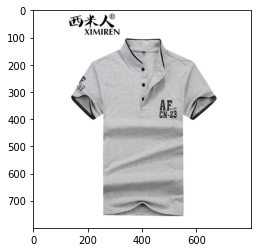

In [59]:
f1 = "test/1032275.jpg"
img1 = PILImage.open(f1)
img_path1 = f1
    
plt.imshow(img1)

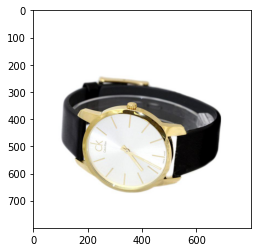

In [61]:
f2 = "test/1019304.jpg"
img2 = PILImage.open(f2)
img_path2 = f2
plt.imshow(img2)

In [51]:
data_transform = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

In [62]:
input_batch = data_transform([img1, img2])
input_batch.shape

TypeError: img should be PIL Image. Got <class 'list'>

In [53]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
model.eval()
with torch.no_grad():
    logits, features = model(input_batch)

In [55]:
features[0]

tensor([0.2921, 0.9150, 0.7604,  ..., 0.5312, 0.1688, 0.2729], device='cuda:0')

In [56]:
probs = torch.nn.functional.softmax(logits[0], dim=0)

In [57]:
torch.argmax(probs).item()
# print(probs[610])

610

In [38]:
out[0].squeeze()

tensor([0.3497, 0.5669, 0.1649,  ..., 0.1641, 0.1008, 0.2258], device='cuda:0')

In [28]:
import ast
file = open("imagenet.txt", "r")
contents = file.read()
dictionary = ast.literal_eval(contents)

In [29]:
description = dictionary[class_id]

In [21]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

db = "visualsearch"
user = "visualsearch"
password = "visualsearch"
host = "localhost"
port = 5432 
engine = create_engine(f"postgres://{user}:{password}@{host}:{port}/{db}")

if not database_exists(engine.url):
    create_database(engine.url)

print(database_exists(engine.url))

True


In [22]:
from sqlalchemy.ext.declarative import declarative_base

In [23]:
Base = declarative_base()

In [54]:
from sqlalchemy import Column, Integer, Float, ARRAY, String, ForeignKey
from sqlalchemy.orm import relationship

class Category(Base):
    __tablename__ = 'categories'
    
    id = Column(Integer, primary_key=True)
    description = Column(String)
    images = relationship("Image", back_populates="category")
    
class Image(Base):
    __tablename__ = 'images'
    
    id = Column(Integer, primary_key=True)
    path = Column(String)
    features = Column(ARRAY(Float))
    category_id = Column(Integer, ForeignKey('categories.id'))
    category = relationship("Category", back_populates="images")

In [13]:
Base.metadata.create_all(engine)

In [66]:
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)

In [67]:
session = Session()

In [32]:
for k,v in dictionary.items():
    category = Category(id= k, description=v)
    session.add(category)

In [33]:
session.commit()

In [100]:
category = session.query(Category).filter(Category.id == class_id).first()

In [98]:
features = features.cpu().numpy()

In [99]:
feat_list = features.tolist()

In [101]:
image = Image(path=img_path, features=feat_list, category=category)

In [102]:
session.add(image)

In [103]:
session.commit()

In [104]:
a = session.query(Image).all()

In [105]:
a[1].category.description

'jersey, T-shirt, tee shirt'